Welcome to the Equator Evaluator.  This note book is designed test the state-of-the-art LLM both locally or via API.
We have chosen to use a single api with openrouter simply because they are OpenAI compatible and provide over 276 models to evaluate.

Addionally are able to evaluate any local Ollama based model, with a litle hacking you can evaluate any model locally or remotely which uses the OpenAI API format.  Please be mindful the spead of evaluation will be different when evaluating local models vs remote API model because of your local machine memory constrains.   Our EQUATOR Evaluator is ran locally but can be hosted on a remote server if you like. 

For the evaluation, we will use the OpenAI API to access their OpenRouter models. We have evaluated the free models to ensure everything works as expected.  Please note that the evaluation will be slower when evaluating local models vs remote API models due to your local machine memory constraints.  Our official Model evaluations presented on our website.  We will maintain a list of over 1005 resoning and logic questions to evaluate  will be held privately  so that we can ensure our evaluation results are fair.   

Our tool is flexible enough to handle any QA sort of evaluations, legal, medical, financial, etc.  which can be added  to the linguistic_benchmark.json to make it your own. Our project is intresed finding those areas with LLM where they fail from a logic and resoning perspective.
This will of courese help the community understand where the week points are and where to strethtn the LLM.  I watermark for us is when LLM can really reach human level problem solving .  We have found LLMs to be easly tricked into the wrong answers .  The EQUATOR evaluator will know when LLM  get good enough to match human capabilities.  

Our next mission with our EQUATOR Evaluator is to add vision.  In addition we will be releasnig better reasoning models that can be run locally.









To get started, please follow these steps:

1. **Obtain Your OpenRouter Key**  
   Visit https://openrouter.ai/settings/keys to get your OpenRouter key.

2. **Add Funds to Your Account**  
   Make sure to add a few dollars to your account so you can use any of the models they provide. For more information, visit https://openrouter.ai/models.

3. **Create a .env File**  
   In your root directory, create a .env file with the following line:  
   ```
   OPENROUTER_KEY="<add your API key from OpenRouter>"
   ```

4. **Install Ollama Locally**  
   Since we will be using LLaMa 3.2 3b as our evaluator, please install Ollama locally. Note that this model can be changed, but if you do so, you will need to edit the line in the `auto_eval_bernard_llm_vector_db_remote_qa.py` file at line 385:  
   ```python
   response = self.generate_chat(
       model="llama3.2", messages=evaluator_system_prompt, stream=False
   )
   ```

5. **Download Ollama**  
   You can download Ollama from https://ollama.com/.

6. **Pull the LLaMa Model**  
   Run the following command to pull the latest LLaMa model:  
   ```bash
   ollama pull llama3.2:latest
   ```

7. **Run Ollama**  
   Finally, execute Ollama with the command:  
   ```bash
   ollama run llama3.2
   ``` 

Make sure to follow each step carefully to ensure everything is set up correctly!




 Make sure you create a new python virtual environment and activate it! Run the below cell once!

In [1]:
%pip install -r requirements.txt 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports just need to run it to but not an issue if you run it multiple times. 

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
import os
import re
import json
import requests
import chromadb
import time 
from loguru import logger

from charting import create_performance_chart
from utils import get_llm_stats, load_all_llm_answers_from_json
from openai import OpenAI

# import csv
import sqlite3
from datetime import datetime  # Correct import
import pandas as pd
from IPython.display import display
from auto_eval_bernard import Bernard_Controller, VectorDB_Controller, extract_model_parts


## User Instructions :  Variables
This section allows us to configure various configurations of the LLM Evaluator. For example if you just want to run the static analysis just comment out the llm_evaluate in the execution list.  You can also set the models you like to evaluate.  We are using OpenAI api call to the openrouter_models.  Change them to the models you like to evaluate.   Open router has about 275 models to choose.  They also have free models which are limited to about 200 calls per day. So you will need to create a paid account and use the none free models to avoid the limitation.  We have evaluated the free models just to test the code and make sure everything works as expected.



With respect to keepVectorDB you can set it to true to avoid imputing the data if you have already done it.  Please note that we input the data from linguistic_bechmark.json.  You are free to customize it for your purposes.  This data is the source of truth for our evaluator.  It is the answer key for grading the  "student".  

Also with respect to folder directory structures,  you can hard code the date which will keep using the same directory structure.   This section allows you to configure various settings for the LLM Evaluator. For instance, if you only want to run the static analysis, simply comment out the `llm_evaluate` in the execution list. You can also specify the models you wish to evaluate. We use the OpenAI API to access the openrouter models, and you can change them to any models of your choice. OpenRouter offers about 275 models, including free options limited to approximately 200 calls per day. To avoid this limitation, you will need to create a paid account to access the non-free models. We have evaluated the free models to test the code and ensure everything works as expected.

Regarding the `keepVectorDB` setting, you can set it to true to prevent re-inputting data if you have already done so. Please note that we input the data from `linguistic_benchmark.json`. Feel free to customize this file for your purposes, as it serves as the source of truth for our evaluator and acts as the answer key for grading the "student."

Additionally, concerning folder directory structures, you can hard-code the date to maintain a consistent directory structure.



In [2]:

execution_steps = [
        "llm_evaluate",
        "generate_statistics",
    ]

local_student = "llm"
openrouter_models = ["google/learnlm-1.5-pro-experimental:free","meta-llama/llama-3.2-11b-vision-instruct:free",
                        "nousresearch/hermes-3-llama-3.1-405b:free","qwen/qwen-2-7b-instruct:free","microsoft/phi-3-medium-128k-instruct:free"]
answer_rounds = 2 # Number of rounds of questions to ask each model
benchmark_name = "Bernard"
# Change to false if you want a new vector db
keepVectorDB = False
# date_now="2024-11-30"  # datetime.now().strftime('%Y-%m-%d')
date_now = datetime.now().strftime('%Y-%m-%d')
folder_name = f"{date_now}-{benchmark_name}"

auto_eval_save_path = f"./{folder_name}/auto_eval_outputs"
stats_save_path = f"./{folder_name}/tables_and_charts"

Extracted Lab name: google
Extracted model name: learnlm-1.5-pro-experimental


2024-12-12 16:59:03.474 | INFO     | auto_eval_bernard:VectorDB_Controller:428 - [{'id': 1, 'category': 'Puzzle', 'question': 'You have six horses and want to race them to see which is fastest. What is the best way to do this?', 'response': 'Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.'}, {'id': 2, 'category': 'Puzzle', 'question': "Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?", 'response': 'It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.'}, {'id': 3, 'category': 'Spatial', 'question': 'You are playing Russian roulette with a six-shooter revolver. 

1. GETTING BERNARD LLM Evaluator ANSWERS

----- Round: 1 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  google/learnlm-1.5-pro-experimental:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

Evaluate whether the STUDENT Answer matches the answer key given. If it does, assign a score of 100% Otherwise you must assign a score of 0%.  Provide a very short explanation on why.  
Just focus o

2024-12-12 16:59:14.202 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:16.218 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Race them all at the same time if you have enough space; otherwise, race them in groups and compare the winners of each race." 
}
```

2024-12-12 16:59:21.612 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 16:59:21.614 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  google/learnlm-1.5-pro-experimental:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON o

2024-12-12 16:59:23.647 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:26.337 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Yes, it is to my advantage to switch my choice. Since I did not reveal my choice to the host and he asked about a specific door there is new information. There is a 2/3 probability the car is behind door number 2. There is a 1/3 probability that the car is behind door number 1."
}
```

2024-12-12 16:59:28.711 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {"score": 0}
2024-12-12 16:59:28.711 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  google/learnlm-1.5-pro-experimen

2024-12-12 16:59:30.759 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:32.161 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Yes, he should spin again." 
}
```

2024-12-12 16:59:34.496 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 100}
2024-12-12 16:59:34.497 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.

----- Round: 2 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  google/learnlm-1.5-pro-experimental:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

Evaluate wh

2024-12-12 16:59:36.562 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:38.169 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Race them all at the same time in a single race." 
}
```

2024-12-12 16:59:40.478 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 16:59:40.479 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  google/learnlm-1.5-pro-experimental:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON o

2024-12-12 16:59:42.512 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:45.577 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Yes, it is to my advantage to switch my choice. Since I did not get to see what was behind my original door choice the probalities have not changed from the intial 1/3 chance. The host however has knowledge that I do not. By asking me if I want to switch to door number 2, he is giving me information. It would be to my advantage to always switch doors in this scenario." 
}
```

2024-12-12 16:59:48.228 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: ```json
{
    "score": 0
}
```

The student's answer does not match the answer key, so they receive a score of 0.
2024-12-12 16:59:48.229 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  google/learnlm-1.5-pro-experimen

2024-12-12 16:59:50.271 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  google/learnlm-1.5-pro-experimental:free


2024-12-12 16:59:51.761 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: ```json
{
"student_answer": "Yes, he should spin again." 
}
```

2024-12-12 16:59:54.085 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 100}
2024-12-12 16:59:54.086 | INFO     | auto_eval_bernard:create_template_json:74 - learnlm-1.5-pro-experimental
2024-12-12 16:59:54.097 | INFO     | auto_eval_bernard:VectorDB_Controller:428 - [{'id': 1, 'category': 'Puzzle', 'question': 'You have six horses and want to race them to see which is fastest. What is the best way to do this?', 'response': 'Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.'}, {'id': 2, 'category': 'Puzzle', 'question': "Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-google-learnlm-1.5-pro-experimental.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.
Extracted Lab name: meta-llama
Extracted model name: llama-3.2-11b-vision-instruct
1. GETTING BERNARD LLM Evaluator ANSWERS

----- Round: 1 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vision-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer

2024-12-12 17:00:03.735 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:04.830 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Create a starting line and have all six horses start racing at the same time, using electronic timing to accurately measure the finish time and determine the fastest horse.'}
2024-12-12 17:00:07.274 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:00:07.275 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vision-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only retur

2024-12-12 17:00:09.322 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:10.366 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Yes'}
2024-12-12 17:00:12.669 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:00:12.669 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vi

2024-12-12 17:00:14.731 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:15.587 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Yes'}
2024-12-12 17:00:18.056 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {"score": 100}
2024-12-12 17:00:18.057 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.

----- Round: 2 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vision-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

E

2024-12-12 17:00:20.106 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:20.983 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'I would start by running the six horses simultaneously and using a stopwatch to measure the time it takes each of them to cross the finish line. This way, I can quickly and accurately determine which horse is the fastest. The exact distance and course of the race would depend on the specific needs and resources of the racing venue.'}
2024-12-12 17:00:23.447 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {"score": 100}
2024-12-12 17:00:23.447 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vision-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only retur

2024-12-12 17:00:25.488 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:26.288 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Yes, it is to your advantage to switch your choice.'}
2024-12-12 17:00:28.662 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:00:28.663 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  meta-llama/llama-3.2-11b-vi

2024-12-12 17:00:30.712 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  meta-llama/llama-3.2-11b-vision-instruct:free


2024-12-12 17:00:31.638 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Yes'}
2024-12-12 17:00:34.063 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {"score": 100}
2024-12-12 17:00:34.063 | INFO     | auto_eval_bernard:create_template_json:74 - llama-3.2-11b-vision-instruct
2024-12-12 17:00:34.073 | INFO     | auto_eval_bernard:VectorDB_Controller:428 - [{'id': 1, 'category': 'Puzzle', 'question': 'You have six horses and want to race them to see which is fastest. What is the best way to do this?', 'response': 'Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.'}, {'id': 2, 'category': 'Puzzle', 'question': "Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instea

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-meta-llama-llama-3.2-11b-vision-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.
Extracted Lab name: nousresearch
Extracted model name: hermes-3-llama-3.1-405b
1. GETTING BERNARD LLM Evaluator ANSWERS

----- Round: 1 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1-405b:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer ke

2024-12-12 17:00:43.697 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:00:52.875 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: Here is my reasoning and final answer in the requested JSON format:

To determine the fastest horse, we need to race them against each other. With 6 horses, the minimum number of races to find the fastest is 5 - race one horse against each of the other 5. However, this doesn't account for finding the relative speeds of the other horses.

A better approach is to divide the horses into 2 groups of 3, and race the horses in each group. Take the top 2 finishers from each group, and race those 4 horses. This will determine the fastest overall horse with just 3 races total.

So in summary:
1. Divide the 6 horses into 2 groups of 3 
2. Race the horses in each group (2 races total)
3. Take the top 2 finishers from each group and race them (1 race)
4. The winner is the fastest horse

Final answer: {'student_answer': 'Divide the 6 horses into 2 groups of 3, race each group, then race the top 2 finishers f

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1-405b:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON

2024-12-12 17:00:57.334 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:01:08.296 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: I will reason through this problem step-by-step:

1. There are three doors: one with a gold bar and two with rotten vegetables. The probability of initially choosing the gold bar is 1/3, and the probability of choosing a door with rotten vegetables is 2/3.

2. The host asks if you want to switch to door No. 2 specifically, not just any other door. This is different from the classic Monty Hall problem, where the host opens a door with a goat and then offers a switch.

3. If you initially chose door No. 1 (gold bar), switching to door No. 2 would result in getting rotten vegetables. If you initially chose door No. 2 (rotten vegetables), switching to door No. 2 would keep you with rotten vegetables. If you initially chose door No. 3 (rotten vegetables), switching to door No. 2 would result in getting the gold bar.

4. The probability of winning the gold bar by switching to door No. 2 is 1/3, which 

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1

2024-12-12 17:01:12.802 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:01:20.991 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: I will reason through this problem step by step:

1. The revolver has 6 chambers, and 5 of them are loaded with bullets. This means there is only 1 empty chamber.

2. The opponent spins the chambers, fires at himself, and no bullet comes out. This means he fired the empty chamber, so now there are 5 chambers remaining, all of them loaded.

3. If he spins the chambers again before firing at me, the probability of me being shot is 5/6, as there are 5 bullets and 1 empty chamber.

4. If he does not spin the chambers again, the next chamber in line is definitely loaded, so the probability of me being shot is 1 (or 100%).

Therefore, to minimize the chances of being shot, I should choose to have him spin the chambers again.

Final Answer = {'student_answer': 'Yes, he should spin the chambers again before firing at me.'}
2024-12-12 17:01:23.913 | INFO     | auto_eval_bernard:call_evaluator:400 - Evalu

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.

----- Round: 2 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1-405b:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

Evaluate 

2024-12-12 17:01:25.961 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:01:31.035 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: Here is my final answer in the requested JSON format:

{'student_answer': 'To determine the fastest horse, you should race all six horses at the same time on the same track. This allows you to directly compare their speeds in a single race, rather than having multiple rounds of races which could introduce variables. Have the horses start at the same point, run on identical track conditions, and record their finishing order and times to identify the fastest horse of the group.'}
2024-12-12 17:01:34.268 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: Since the student's answer does not match the exact wording of the answer key, but it conveys a similar idea, I will still assign a score.

Here is the JSON object with the assigned score:

{'score': 0}

Note that while the student's answer provides more detailed explanation and reasoning, which are important in many contexts, 

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1-405b:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON

2024-12-12 17:01:36.318 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:01:47.982 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: I will reason through this problem step-by-step:

1. There are three doors: Door 1, Door 2, and Door 3. 
2. Behind one door is a gold bar, and behind the other two doors are rotten vegetables.
3. I initially choose Door 1. 
4. The host asks if I want to switch to Door 2 instead.

Key observations:
- The host has not opened any doors to reveal what is behind them, unlike in the classic Monty Hall problem.
- There is no indication that the host knows what is behind the doors.
- The host is simply asking if I want to change my initial choice, without providing any additional information.

Therefore, without any additional information, switching from Door 1 to Door 2 does not change the probability of winning the gold bar. In either case, I have a 1/3 chance of choosing the door with the gold bar and a 2/3 chance of choosing a door with rotten vegetables.

Final Answer = {'student_answer': 'No, it i

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  nousresearch/hermes-3-llama-3.1

2024-12-12 17:01:52.561 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  nousresearch/hermes-3-llama-3.1-405b:free


2024-12-12 17:01:59.152 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: I have thought carefully about the question. Since the opponent has already fired the gun once without a bullet coming out, there are now 5 chambers remaining, with 5 bullets. Therefore, if he fires again without spinning, there is a 100% chance I will be shot. If he spins the chambers before firing at me, the probability of being shot decreases to 5/6 or about 83.3%.

Final Answer = {'student_answer': 'He should spin the chambers again before firing at me to decrease the probability of me being shot from 100% to about 83.3%.'}
2024-12-12 17:02:01.677 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:01.678 | INFO     | auto_eval_bernard:create_template_json:74 - hermes-3-llama-3.1-405b
2024-12-12 17:02:01.688 | INFO     | auto_eval_bernard:VectorDB_Controller:428 - [{'id': 1, 'category': 'Puzzle', 'question': 'You have six horses and want to r

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-nousresearch-hermes-3-llama-3.1-405b.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.
Extracted Lab name: qwen
Extracted model name: qwen-2-7b-instruct
1. GETTING BERNARD LLM Evaluator ANSWERS

----- Round: 1 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit all

2024-12-12 17:02:11.346 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:12.755 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {
  "student_answer": "Divide the six horses into two groups of three. Race the two groups separately to find the fastest two horses. Then, race the winners of each group to determine the fastest horse overall."
}
2024-12-12 17:02:15.233 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:15.233 | INFO     | auto_eval_bernard:create_template_json:74 - qwen-2-7b-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'s

2024-12-12 17:02:17.283 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:18.348 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {"student_answer": "Yes, it is to your advantage to switch your choice."}
2024-12-12 17:02:20.808 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:20.809 | INFO     | auto_eval_bernard:create_template_json:74 - qwen-2-7b-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt =

2024-12-12 17:02:22.853 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:25.434 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {"student_answer": "It doesn't matter if the chambers are spun again or not. The probability of a bullet being in the next chamber was 1/6 before spinning, and it remains 1/6 after spinning. Since there are no empty chambers left and five chambers are filled with bullets, the probability of the next chamber being a bullet is actually higher than before spinning (100% chance of a bullet after spinning). However, logically, since the fate of the chamber wasn't altered by the previous shot, the decision to spin does not change the outcome. In practical terms, spinning gives one a false sense of safety and doesn't offer any real benefit in this scenario. The optimal choice here, barring any new information, would be not to spin."}
2024-12-12 17:02:27.880 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:27.881 | INFO     | auto_eval_bernard:create_

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.

----- Round: 2 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

Evaluate whether the STUDENT Answer

2024-12-12 17:02:29.930 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:31.303 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Race three horses in a first-round, then race the top three horses from the first round in a second-round to determine the fastest horse.'}
2024-12-12 17:02:33.627 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:33.627 | INFO     | auto_eval_bernard:create_template_json:74 - qwen-2-7b-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'s

2024-12-12 17:02:35.680 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:37.303 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {'student_answer': 'Yes, it is to your advantage to switch your choice. By switching, you have a 2/3 chance of winning the gold bar, whereas sticking with your original choice gives you a 1/3 chance of winning.'}
2024-12-12 17:02:39.629 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:39.629 | INFO     | auto_eval_bernard:create_template_json:74 - qwen-2-7b-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  qwen/qwen-2-7b-instruct:free
system prompt =

2024-12-12 17:02:41.674 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  qwen/qwen-2-7b-instruct:free


2024-12-12 17:02:43.937 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer: {
  "student_answer": "Spinning the chambers again would be a randomization process, potentially resetting the probability. Since only one chamber contained a bullet after your opponent fired, spinning is essentially randomizing the new positions. If the revolver is fair, you have a 1 in 6 chance of a bullet anywhere, including the last empty chamber after your opponent fired. So, whether your opponent spins the chambers or not doesn't change your probability of survival to this point, assuming the revolver is equipped with six consistent chambers."
}
2024-12-12 17:02:46.450 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:02:46.451 | INFO     | auto_eval_bernard:create_template_json:74 - qwen-2-7b-instruct
2024-12-12 17:02:46.461 | INFO     | auto_eval_bernard:VectorDB_Controller:428 - [{'id': 1, 'category': 'Puzzle', 'question': 'You have six h

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-qwen-qwen-2-7b-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.
Extracted Lab name: microsoft
Extracted model name: phi-3-medium-128k-instruct
1. GETTING BERNARD LLM Evaluator ANSWERS

----- Round: 1 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  microsoft/phi-3-medium-128k-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No parti

2024-12-12 17:02:56.079 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:00.256 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  Final Answer = {'student_answer': 'The best way to determine the fastest horse among your six horses would be to organize a series of races. You can use a simple elimination format where the horses are paired up in races, and the winner of each race progresses to the next round. Continue this process until you have three horses left in the most advanced round. At this point, hold a single race among those three horses to determine the fastest horse. This approach ensures you have a fair and accurate comparison among all horses, and you can minimize potential external factors that might affect individual race outcomes (such as track conditions, horse fatigue, etc.).'}
2024-12-12 17:03:02.633 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:03:02.634 | INFO     | auto_eval_bernard:create_template_json:74 - phi-3-medium-128k-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  microsoft/phi-3-medium-128k-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON

2024-12-12 17:03:04.676 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:11.894 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  After considering the problem carefully, we can use the Monte Carlo simulation method to estimate the probabilities of winning the gold bar for both the strategies - sticking with the original choice or switching the choice. By simulating this problem numerous times, we can approximate the probabilities. Here's the pseudo-code for the problem:

1. Initialize win_counter to 0 and switch_win_counter to 0.
2. Repeat the following N times:
    a. Randomly place the gold bar behind one of the doors (1, 2, or 3).
    b. Randomly choose one of the doors yourself (let's call it user_choice).
    c. If the host asks if you want to switch, update the win_counter based on user_choice and host response, and update the switch_win_counter based on host response and your swapped choice.
3. Calculate the probabilities of winning for sticking and switching choices by dividing win_counter and switch_win_counter 

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  microsoft/phi-3-medium-128k-ins

2024-12-12 17:03:16.343 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:23.022 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  After analyzing the situation, here is the answer:

The probability of successfully avoiding the bullet changes in the second scenario. In the first scenario, when your opponent spins the chambers and fires, the probability of the bullet NOT being in either of the remaining 5 chambers is:
1 (safe chamber) / 6 (total chambers) = 1/6

When the opponent does not spin the chamber the second time and he fires, the probability of the bullet being in the chamber that he fired the first time is:
1 (chamber with fired bullet) / 6 (total chambers) = 1/6

However, the probability of the bullet being in any of the remaining 5 chambers is now higher:
5 (remaining chambers) / 6 (total chambers) = 5/6

Now, let's consider if the opponent spins the chambers again before firing at you. The probability distribution is reset, and each chamber has an equal chance of containing the bullet. Therefore, the probabilit

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_1/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.

----- Round: 2 of 2 -----
prefix == auto_eval-
Executing query with OFFSET=0, LIMIT=1
Processing ID: 1, Category: Puzzle, Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?, Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.
line 484 Model Path  =  microsoft/phi-3-medium-128k-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON object with the score {'score': <0 or 100>}

TASK

Evaluate 

2024-12-12 17:03:27.584 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You have six horses and want to race them to see which is fastest. What is the best way to do this?
Answer: Race them on a single race track with at least six lanes - the order in which they cross the finish line determines which is the fastest.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:30.348 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  {'student_answer': 'The best way to determine which horse is the fastest is to conduct a controlled race where all six horses compete against each other under identical conditions. Set up a predetermined track or course with a standard distance and ensure that start times are synchronized. It is important not to introduce any external factors that could favor one horse over another (e.g., varying track conditions or obstacles). This way, the differences in speed among the horses can be evaluated objectively, and the fastest horse can be determined.'}
2024-12-12 17:03:32.815 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {'score': 0}
2024-12-12 17:03:32.816 | INFO     | auto_eval_bernard:create_template_json:74 - phi-3-medium-128k-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=1, LIMIT=1
Processing ID: 2, Category: Puzzle, Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?, Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.
line 484 Model Path  =  microsoft/phi-3-medium-128k-instruct:free
system prompt ==  SCORING CRITERIA
100%: The response must match the answer key given, even if the student used bad reasoning, logic to arrive at the final answer. 
0%: The does NOT match the answer key given. No partial credit allowed!
You must only return a JSON

2024-12-12 17:03:34.843 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a gold bar; behind the others, rotten vegetables. You pick a door, say No. 1, and the host asks you 'Do you want to pick door No. 2 instead?' Is it to your advantage to switch your choice?
Answer: It is not an advantage to switch. It makes no difference if I switch or not because no additional material information has been provided since the initial choice.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:40.687 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  To determine whether it is advantageous to switch your choice, we can analyze the probability of winning the gold bar in each scenario.

Initial Scenario:
1. If you stick to your initial choice (door No. 1), the probability of it containing the gold bar is 1/3, as there is only 1 gold bar in 3 doors.
2. If you switch your choice, the probability of winning depends on whether door No. 2 has the gold bar or not, which is based on the location of the gold bar and the host's knowledge.

Now, let's consider the possible scenarios:
- If your initial choice (door No. 1) has the gold bar, the host will open door No. 3 (which has rotten vegetables) as it can't have the gold bar, and switching will result in a loss.
- If your initial choice (door No. 1) has rotten vegetables, the host will open door No. 3 (the other door with rotten vegetables), and switching will result in winning.

The probability of e

Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=2, LIMIT=1
Processing ID: 3, Category: Spatial, Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?, Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.
line 484 Model Path  =  microsoft/phi-3-medium-128k-ins

2024-12-12 17:03:45.328 | INFO     | auto_eval_bernard:call_evaluator:349 - Question: You are playing Russian roulette with a six-shooter revolver. Your opponent puts in five bullets, spins the chambers and fires at himself, but no bullet comes out. He gives you the choice of whether or not he should spin the chambers again before firing at you. Should he spin again?
Answer: Yes, you should ask him to spin again. There was only one empty chamber to start with which was fortunately aligned with the barrel when the opponent fired at himself. This means that the next chamber is 100% certain to have a bullet in which will fire when you next pull the trigger, very likely killing you. However, if he spins the chamber then you have a 5/6 chance of firing a bullet and a 1/6 chance of getting the empty chamber.




line 353  = model_path :  microsoft/phi-3-medium-128k-instruct:free


2024-12-12 17:03:47.924 | INFO     | auto_eval_bernard:call_evaluator:364 - Student Answer:  {'student_answer': 'Yes, he should spin again. This is because the initial spin has the same conditions as before (one empty chamber), and spinning again effectively resets the odds. If he doesn't spin again, the odds against him are 5:1. If he does spin again, the odds reset with the same probabilities (1 empty chamber vs. 5 loaded chambers), maintaining the 5:1 odds against him for each shot.'}
2024-12-12 17:03:50.419 | INFO     | auto_eval_bernard:call_evaluator:400 - Evaluator Response: {"score": 100}
2024-12-12 17:03:50.420 | INFO     | auto_eval_bernard:create_template_json:74 - phi-3-medium-128k-instruct


Template JSON created/updated: ./2024-12-12-Bernard/auto_eval_outputs/round_2/auto_eval-microsoft-phi-3-medium-128k-instruct.json
Executing query with OFFSET=3, LIMIT=1
No more records found. Exiting.
Database connection closed.
2. GENERATING STATISTICS
Eval for path: ./2024-12-12-Bernard/auto_eval_outputs
test statistics, all answers {'google-learnlm-1.5-pro-experimental':   category                                           question  \
1   Puzzle  You have six horses and want to race them to s...   
2   Puzzle  Suppose you're on a game show, and you're give...   
3  Spatial  You are playing Russian roulette with a six-sh...   
1   Puzzle  You have six horses and want to race them to s...   
2   Puzzle  Suppose you're on a game show, and you're give...   
3  Spatial  You are playing Russian roulette with a six-sh...   

                                        human_answer  \
1  Race them on a single race track with at least...   
2  It is not an advantage to switch. It makes no ...   

,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count
model,,,,,,
meta-llama-llama-3.2-11b-vision-instruct,50.000000,54.772256,43.826932,16.666667,83.333333,6.0
google-learnlm-1.5-pro-experimental,33.333333,51.639778,41.320428,0.000000,66.666667,6.0
microsoft-phi-3-medium-128k-instruct,33.333333,51.639778,41.320428,0.000000,66.666667,6.0
nousresearch-hermes-3-llama-3.1-405b,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
qwen-qwen-2-7b-instruct,0.000000,0.000000,0.000000,0.000000,0.000000,6.0


f:\pythonprograms\llm_evaluator_beta_sr\charting.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df, x="Model", y="Average", palette=colors, errorbar=None)


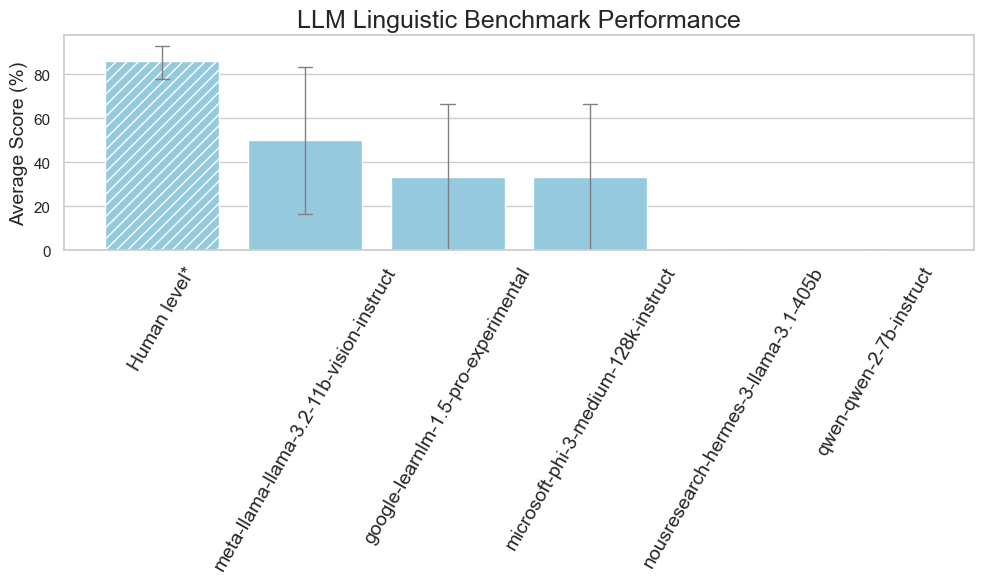

-- DONE STATS --



In [3]:
for model in openrouter_models:
    model_path = model
    lab, student_models = extract_model_parts(model)
    if student_models:
        print(f"Extracted Lab name: {lab}")

        print(f"Extracted model name: {student_models}")
    else:
        print("Model name not found.")
    student_models = [student_models]

    VectorDB_Controller(keepVectorDB)


    if "llm_evaluate" in execution_steps:
        print("1. GETTING BERNARD LLM Evaluator ANSWERS")
        for n in range(answer_rounds):
            print(f"\n----- Round: {n+1} of {answer_rounds} -----")
            answer_save_path_round = f"{auto_eval_save_path}"

            Bernard_Controller(
                model_path,
                lab,
                student_models,
                answer_save_path_round=answer_save_path_round,
                count=n,
                prefix_replace="auto_eval-",
            )

if "generate_statistics" in execution_steps:
    sub_eval_folders = [f"/round_{r+1}" for r in range(answer_rounds)]

    print("2. GENERATING STATISTICS")
    all_stats_dfs = {}
    save_info = [
        {
            "path": auto_eval_save_path,
            "chart_title": "LLM Linguistic Benchmark Performance",
            "type": "",
        }
    ]
    for info in save_info:
        save_path = info["path"]
        chart_title = info["chart_title"]
        info_type = info["type"]
        print("Eval for path:", save_path)
        all_llm_evals = load_all_llm_answers_from_json(
            save_path,
            prefix_replace="auto_eval-",
            sub_folders=sub_eval_folders,
        )
        stats_df = get_llm_stats(
            all_llm_evals, stats_save_path, file_suffix=info_type, bootstrap_n=10000
        )

        display(stats_df)

        barplot, plt = create_performance_chart(
            stats_df.reset_index(),
            chart_title,
            highlight_models=["o1-preview"],
        )
        barplot.figure.savefig(f"{stats_save_path}/performance_chart{info_type}.png")
        plt.show()
        all_stats_dfs[chart_title] = stats_df

    print("-- DONE STATS --\n")

Additional Charts 

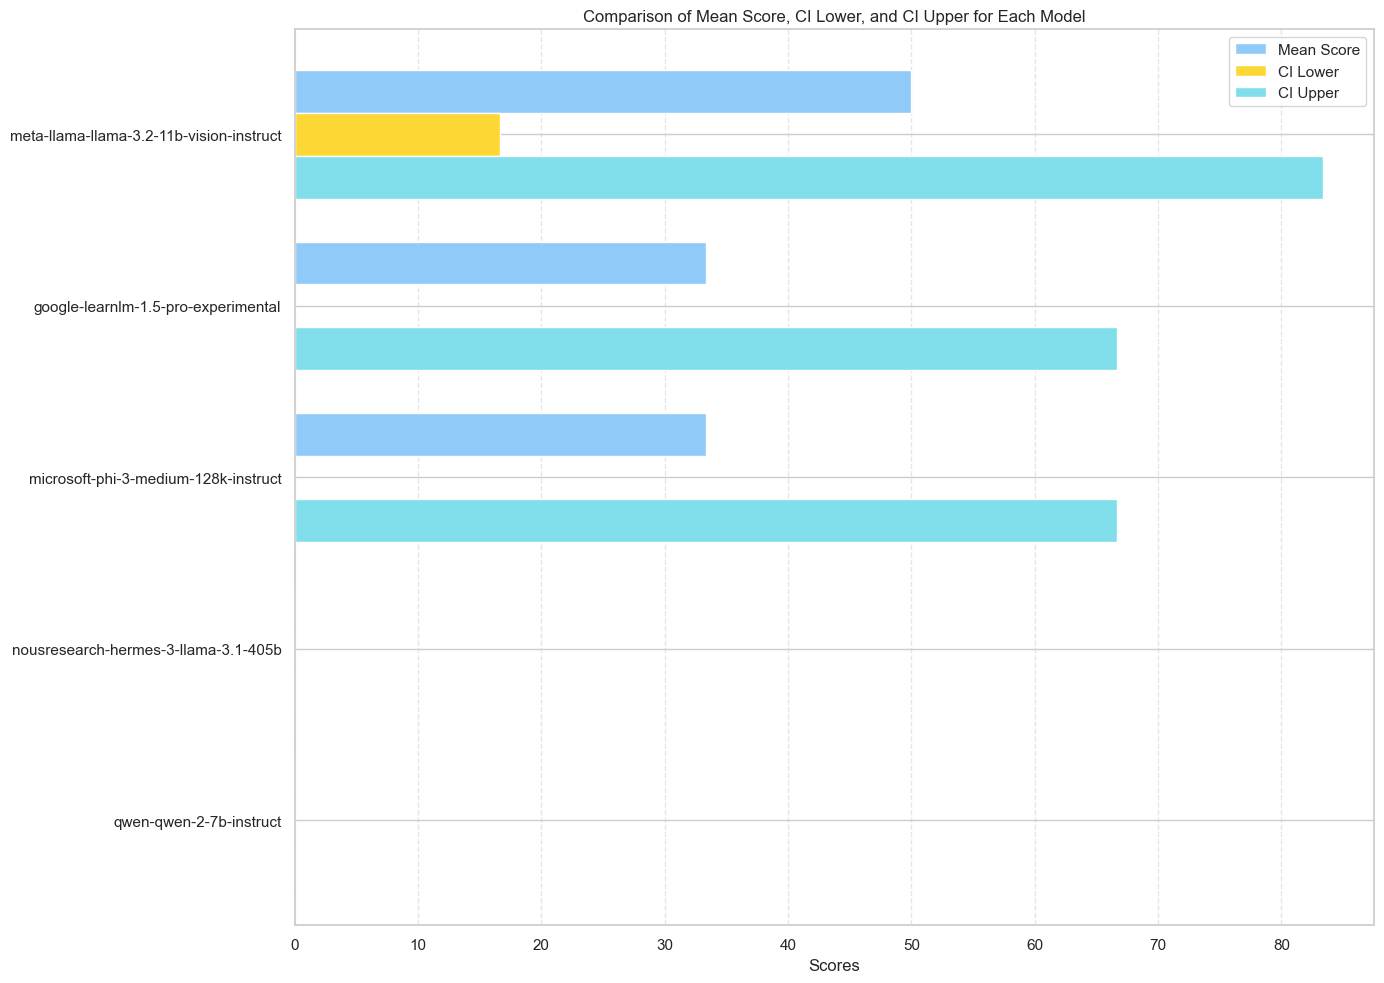

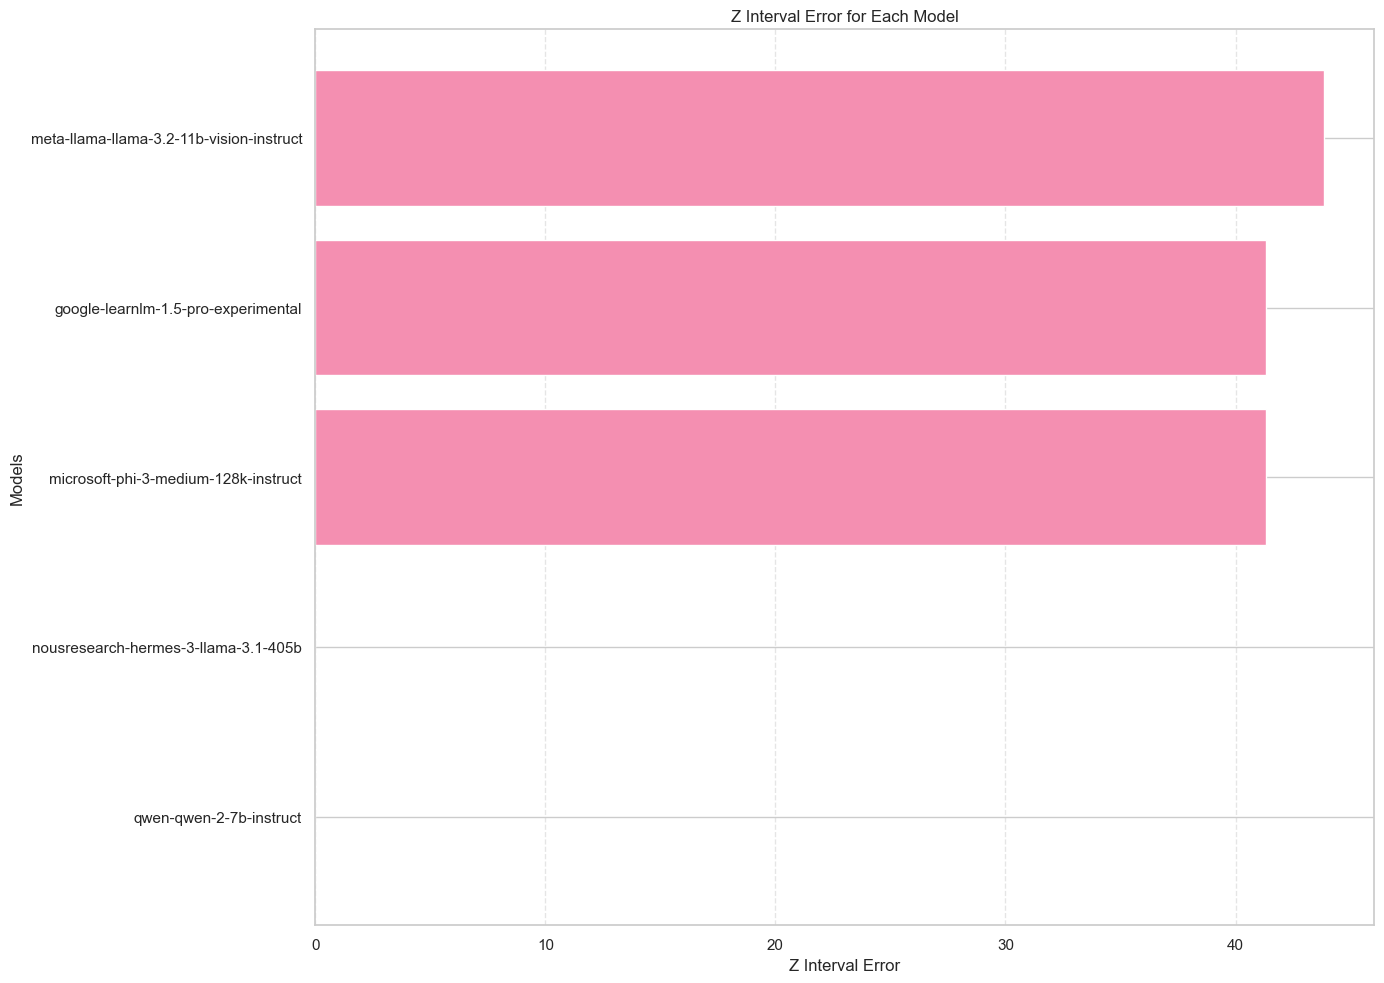

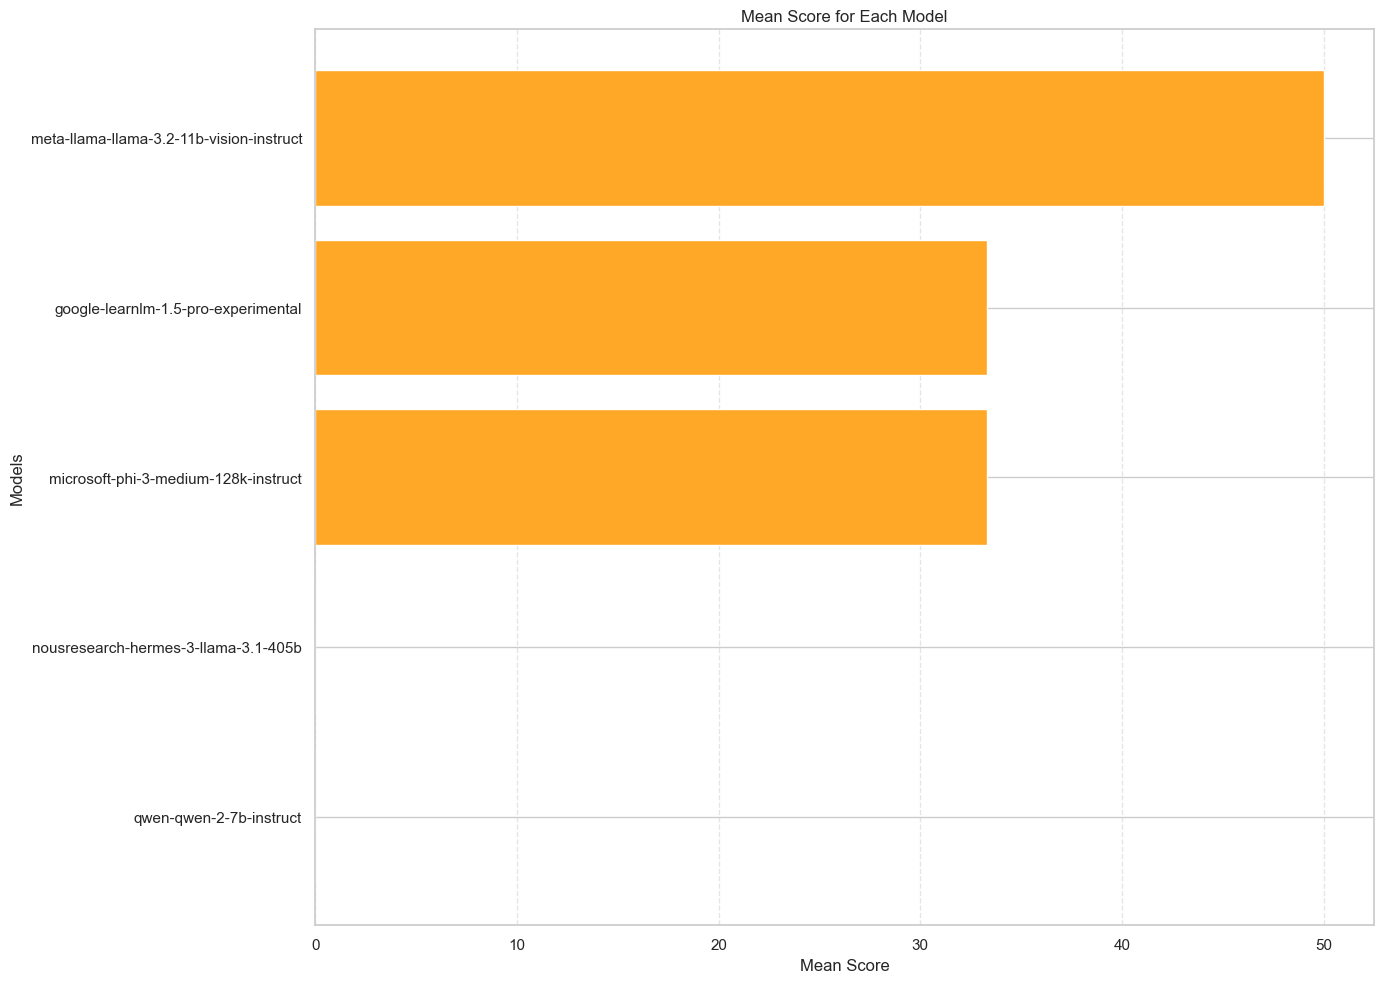

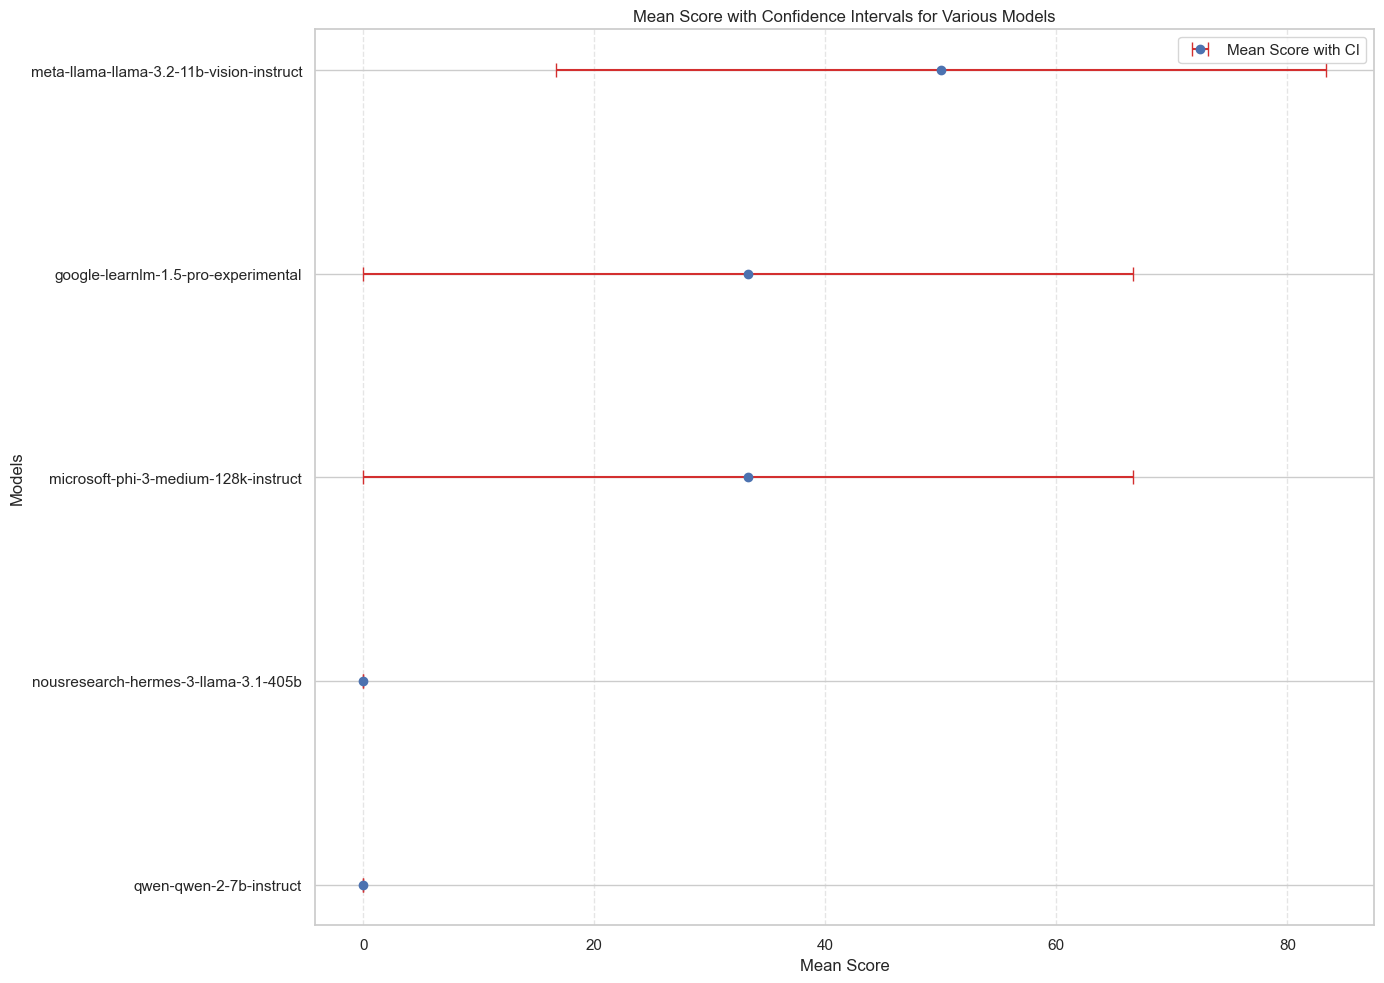

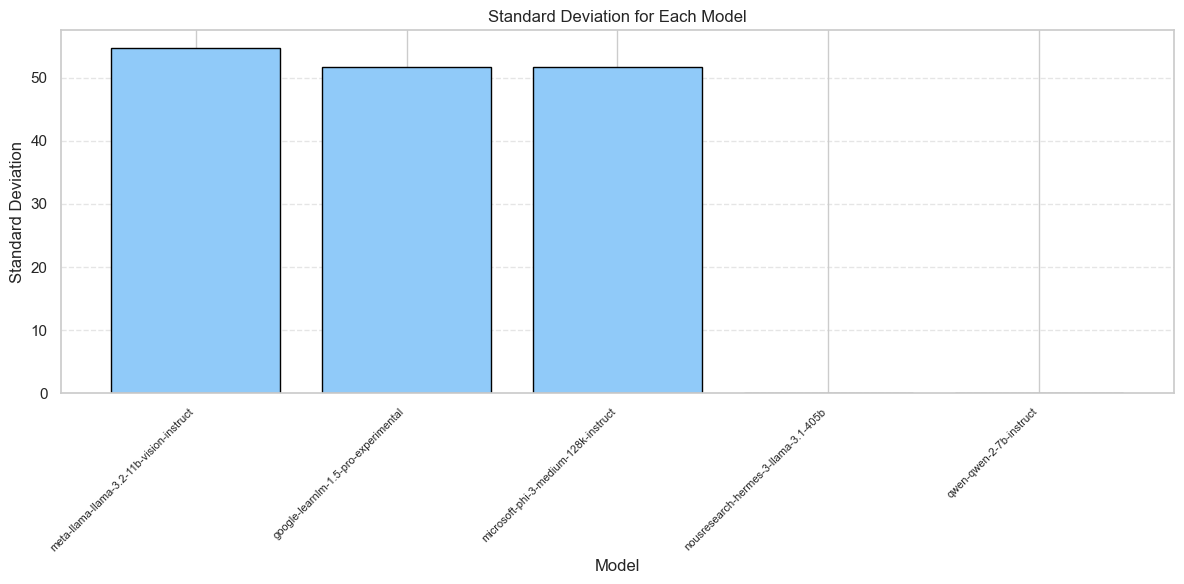

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from CSV file
df = pd.read_csv(f'{stats_save_path}\\final_stats.csv')

# Sorting DataFrame by Mean Score in descending order for better visualization
df_sorted = df.sort_values(by='mean_score', ascending=False)

# Color palette from the provided PDF
colors = {
    'blue_200': '#90caf9',
    'yellow_600': '#fdd835',
    'pink_200': '#f48fb1',
    'cyan_200': '#80deea',
    'orange_400': '#ffa726',
    'deep_purple_A100': '#b388ff',
    'red_700': '#d32f2f'
}

# Horizontal Bar Chart for Mean Score, CI Lower, and CI Upper for Each Model (Sorted in Descending Order)
y = np.arange(len(df_sorted['model']))  # the label locations
height = 0.25  # the height of the bars

fig, ax = plt.subplots(figsize=(14, 10))
bars1 = ax.barh(y - height, df_sorted['mean_score'], height, label='Mean Score', color=colors['blue_200'])
bars2 = ax.barh(y, df_sorted['ci_lower'], height, label='CI Lower', color=colors['yellow_600'])
bars3 = ax.barh(y + height, df_sorted['ci_upper'], height, label='CI Upper', color=colors['cyan_200'])

# Adding labels and title
ax.set_yticks(y)
ax.set_yticklabels(df_sorted['model'])  # Labels on the left
ax.set_xlabel('Scores')
ax.set_title('Comparison of Mean Score, CI Lower, and CI Upper for Each Model')
ax.invert_yaxis()  # Higher values at the top
ax.legend()

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Horizontal Bar Chart for Z Interval Error for Each Model (Sorted in Descending Order)
fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(df_sorted['model'], df_sorted['z_interval_error'], color=colors['pink_200'])

plt.ylabel('Models')
plt.xlabel('Z Interval Error')
plt.title('Z Interval Error for Each Model')
ax.invert_yaxis()  # Higher values at the top
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Horizontal Bar Chart for Mean Score of Each Model (Sorted in Descending Order)
fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(df_sorted['model'], df_sorted['mean_score'], color=colors['orange_400'])

plt.ylabel('Models')
plt.xlabel('Mean Score')
plt.title('Mean Score for Each Model')
ax.invert_yaxis()  # Higher values at the top
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Plotting Mean Score with Error Bars for Confidence Intervals (Sorted in Descending Order)
ci_error = (df_sorted['ci_upper'] - df_sorted['ci_lower']).abs() / 2
plt.figure(figsize=(14, 10))
plt.errorbar(df_sorted['mean_score'], df_sorted['model'], 
             xerr=ci_error, 
             fmt='o', ecolor=colors['red_700'], capsize=5, label='Mean Score with CI')
plt.ylabel('Models')
plt.xlabel('Mean Score')
plt.title('Mean Score with Confidence Intervals for Various Models')
plt.gca().invert_yaxis()  # Higher values at the top
plt.tight_layout()
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# Bar Chart of Standard Deviations for Each Model

# Create a bar chart where each model is represented individually
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting standard deviation scores for each model
ax.bar(df['model'], df['std_dev_score'], color='#90caf9', edgecolor='black')

# Adding labels and title
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Model')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation for Each Model')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()



## Token Analysis
This provides a straightforward measure of the tokens used per category across all models in a specific run.


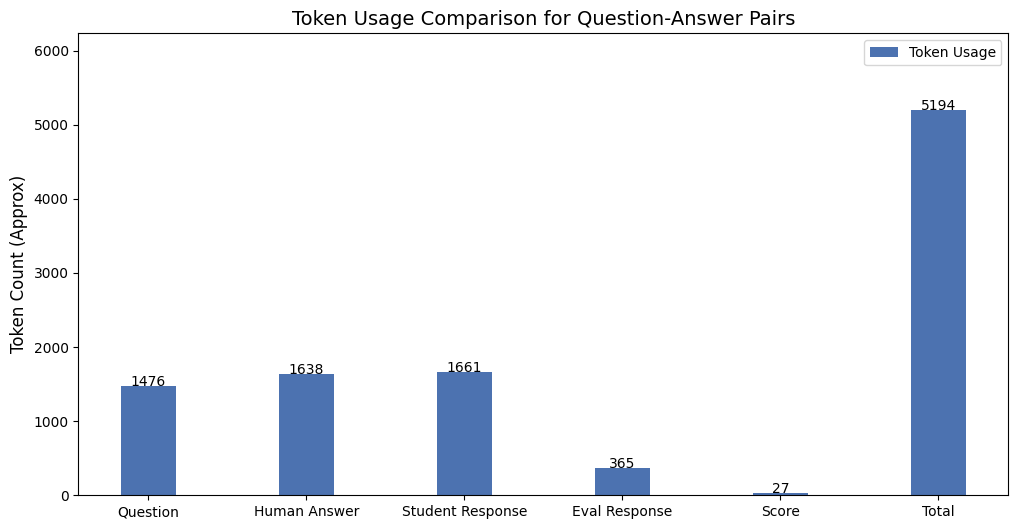

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Base directory containing rounds (e.g., 'auto_eval_save_path')
auto_eval_save_path = auto_eval_save_path

# Directory to save the output files
charts_dir = stats_save_path

os.makedirs(charts_dir, exist_ok=True)

# Number of rounds
answer_rounds = 2  # Update as needed

# Function to collect all JSON file paths in a directory
def collect_json_files(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')]

# Function to process JSON files
def process_json_files(file_paths):
    results = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        for _, entry in data.items():
            # Token calculation for each category
            question_tokens = count_tokens(entry.get("question", ""))
            human_answer_tokens = count_tokens(entry.get("human_answer", ""))
            model_answer_input_tokens = count_tokens(entry.get("model_answer", ""))
            eval_response_tokens = count_tokens(entry.get("eval_response", ""))
            score_tokens = count_tokens(str(entry.get("score", "")))
            bernard_evaluator_response_tokens = count_tokens(entry.get("bernard_evaluator_response", ""))
            
            results.append({
                "question_tokens": question_tokens,
                "human_answer_tokens": human_answer_tokens,
                "model_answer_input_tokens": model_answer_input_tokens,
                "eval_response_tokens": eval_response_tokens,
                "score_tokens": score_tokens,
                "bernard_evaluator_response_tokens": bernard_evaluator_response_tokens,
                "total_tokens": question_tokens + human_answer_tokens + model_answer_input_tokens +
                                eval_response_tokens + score_tokens + bernard_evaluator_response_tokens
            })
    return results

# Function to calculate tokens based on the rule: 1 token = 4 characters
def count_tokens(text):
    return max(1, len(text) // 4)

# Process files for each round
all_results = []

for round_num in range(1, answer_rounds + 1):
    round_dir = os.path.join(auto_eval_save_path, f'round_{round_num}')
    
    # Collect files from the round
    json_files = collect_json_files(round_dir)

    # Process the files in the round
    all_results.extend(process_json_files(json_files))

# Convert results to DataFrame for analysis
df = pd.DataFrame(all_results)

# Summarize total tokens per category for comparison
summary = df.sum()

# Create a token usage comparison DataFrame
categories = ["Question", "Human Answer", "Student Response", "Eval Response", "Score",  "Total"]
token_usage = [
    summary["question_tokens"],
    summary["human_answer_tokens"],
    summary["model_answer_input_tokens"],
    summary["eval_response_tokens"],
    summary["score_tokens"],
    summary["total_tokens"]
]

# Create a DataFrame for the results
usage_df = pd.DataFrame({
    "Category": categories,
    "Token Usage": token_usage
})

# Save the token comparison table to a CSV file
usage_csv_path = os.path.join(charts_dir, 'token_usage_comparison.csv')
usage_df.to_csv(usage_csv_path, index=False)

# Create a bar chart for token usage comparison
x = np.arange(len(categories))

# Plot Token Usage
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(x, token_usage, width, label="Token Usage", color="#4C72B0")

# Add values above the bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f"{int(bar.get_height())}", ha="center", fontsize=10)

# Adjust the y-axis dynamically
max_value = max(token_usage)
ax.set_ylim(0, max_value * 1.2)  # Add 20% headroom above tallest bar

# Add labels, title, and legend
ax.set_ylabel("Token Count (Approx)", fontsize=12)
ax.set_title("Token Usage Comparison for Question-Answer Pairs", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Save the chart as a PNG file
chart_path = os.path.join(charts_dir, 'token_usage_comparison_chart.png')
plt.savefig(chart_path, bbox_inches='tight')
plt.show()

